In [1]:
import os
import sys
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

# to get deterministic output
tf.random.set_seed(123)

sys.path.append(os.path.abspath(".."))

### Loading the Dataset

In [2]:
df = pd.read_csv("../datasets/perceptron_toydata-truncated.txt", sep="\t")
df

,x1,x2,label
0,0.77,-1.14,0
1,-0.33,1.44,0
2,0.91,-3.07,0
3,-0.37,-1.91,0
4,-0.63,-1.53,0
5,0.39,-1.99,0
6,-0.49,-2.74,0
7,-0.68,-1.52,0
8,-0.10,-3.43,0
9,-0.05,-1.95,0


In [3]:
X_train = df[["x1", "x2"]].values
y_train = df["label"].values

print("Train set:", X_train.shape, y_train.shape)

Train set: (20, 2) (20,)


In [4]:
# scaling for better convergence
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [5]:
counts = Counter(y_train)
for key, value in counts.items():
    print(f"{key}: {value}")

0: 10
1: 10


### Define the DataLoader

In [6]:
# Reshape labels
y_train_reshape = y_train.reshape(-1, 1)

# TensorFlow dataset for mini-batching
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_reshape)).shuffle(buffer_size=1024).batch(batch_size=10)

### Visualize the Dataset

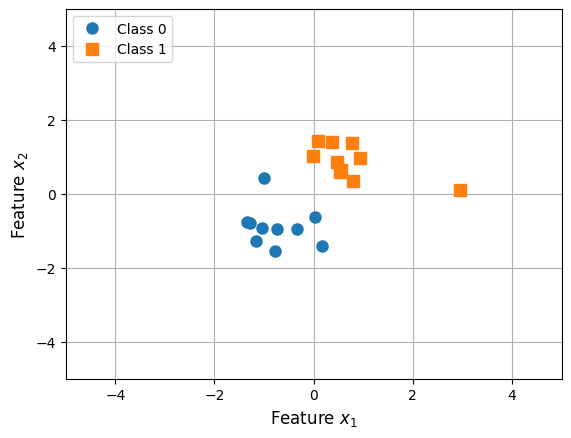

In [7]:
from modules.plotting_helper import plot_feature2d
plot_feature2d(X_train, y_train, markersize=8)

### Design the Model

In [8]:
class LogisticRegression(tf.keras.Model):
  def __init__(self, input_dim):
    super().__init__()
    self.linear = tf.keras.layers.Dense(1, activation=None)

  def call(self, x):
    logits = self.linear(x)
    return logits
  
  def predict(self, x):
    return tf.sigmoid(self(x))

model = LogisticRegression(input_dim=2)
optimizer = tf.keras.optimizers.SGD(learning_rate=1.00)
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
model.summary()

Model: "logistic_regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the Model

In [9]:
def train(model, optimizer, loss_fn, num_epochs):
    history = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for  batch_idx, (x_batch, y_batch) in enumerate(train_ds):
            # forward pass
            with tf.GradientTape() as tape:
                logits = model(x_batch, training=True)
                loss = loss_fn(y_batch, logits)

            # backward pass
            gradients = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))
            
            epoch_loss += abs(loss.numpy())
            history.append(loss.numpy())
            print(f' -> batch: {batch_idx+1:03d} | loss: {loss:.2f}')
            
        history.append(epoch_loss)
        print(f'Epoch: {epoch+1:03d}/{num_epochs:03d} | epoch_loss: {epoch_loss:.2f}')
    return history
        
history = train(model, optimizer, loss_fn, num_epochs=20)

 -> batch: 001 | loss: 1.05
 -> batch: 002 | loss: 0.72
Epoch: 001/020 | epoch_loss: 1.77
 -> batch: 001 | loss: 0.38
 -> batch: 002 | loss: 0.33
Epoch: 002/020 | epoch_loss: 0.71
 -> batch: 001 | loss: 0.21
 -> batch: 002 | loss: 0.23
Epoch: 003/020 | epoch_loss: 0.43
 -> batch: 001 | loss: 0.20
 -> batch: 002 | loss: 0.13
Epoch: 004/020 | epoch_loss: 0.33
 -> batch: 001 | loss: 0.16
 -> batch: 002 | loss: 0.10
Epoch: 005/020 | epoch_loss: 0.26
 -> batch: 001 | loss: 0.15
 -> batch: 002 | loss: 0.08
Epoch: 006/020 | epoch_loss: 0.23
 -> batch: 001 | loss: 0.09
 -> batch: 002 | loss: 0.10
Epoch: 007/020 | epoch_loss: 0.19
 -> batch: 001 | loss: 0.09
 -> batch: 002 | loss: 0.09
Epoch: 008/020 | epoch_loss: 0.17
 -> batch: 001 | loss: 0.06
 -> batch: 002 | loss: 0.10
Epoch: 009/020 | epoch_loss: 0.16
 -> batch: 001 | loss: 0.06
 -> batch: 002 | loss: 0.09
Epoch: 010/020 | epoch_loss: 0.15
 -> batch: 001 | loss: 0.05
 -> batch: 002 | loss: 0.09
Epoch: 011/020 | epoch_loss: 0.14
 -> batch:

In [10]:
weights, bias = model.layers[0].get_weights()
print("Bias:", bias)
print("Weights:", weights)

Bias: [-0.13992186]
Weights: [[2.5179145]
 [2.532404 ]]


### Evaluate the model

In [11]:
predictions = model.predict(X_train)
y_preds = predictions > 0.5

train_acc = accuracy_score(y_train, y_preds)
print(f"Train Accuracy: {train_acc:.2f}")

cmat = confusion_matrix(y_train, y_preds)
print("Confusion Matrix:")
print(cmat)

Train Accuracy: 1.00
Confusion Matrix:
[[10  0]
 [ 0 10]]


### Visualize the Results

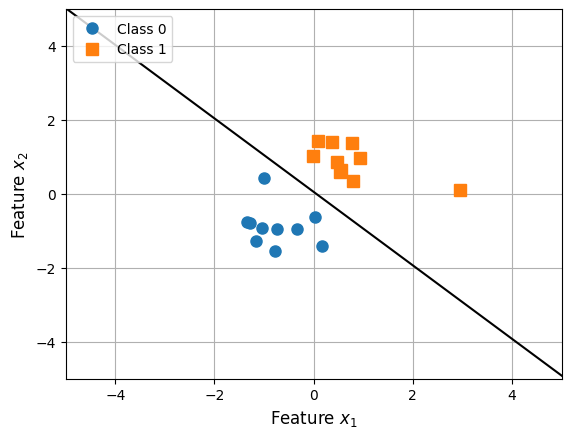

In [12]:
plot_feature2d(X_train, y_train, bias, weights, markersize=8)